# Кластеризация

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
import matplotlib.pyplot as plt
%matplotlib inline

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

# 1. KMeans
Идея KMeans предельно проста - давайте метки точек обновлять в соответствии с ближайшим центроидом, а положения центроидов - в соответствие с с точками, и повторять этот процесс итерационно, пока не надоест. На картинке ниже показан KMeans с n_clusters=3

![](https://datasciencelab.files.wordpress.com/2013/12/p_n200_k3.gif)

## Сгенерируем данные

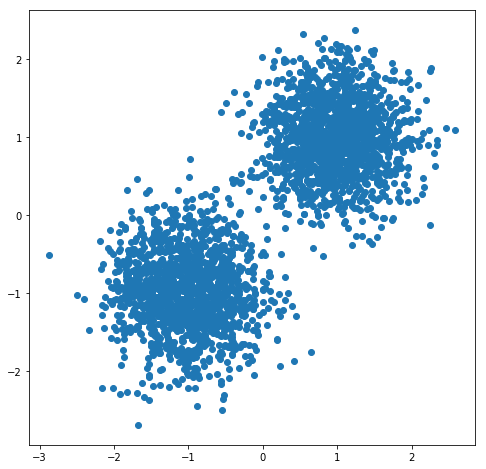

In [2]:
from sklearn.cluster import KMeans

from sklearn.datasets.samples_generator import make_blobs
np.random.seed(0)
centers = [[1, 1], [-1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, 
                            centers=centers, 
                            cluster_std=0.5)

def plot_cluster_data(X, c=[1]*X.shape[0], mu=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    if len(np.unique(c)) == 1:
        ax.plot(X[:,0], X[:,1], 'o')
    else:
        ix = np.where(c==1)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='red')
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ix = np.where(c==0)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='green')
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)
    if not mu is None:
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)        
    plt.show()
    
plot_cluster_data(X)


## Обучим KMeans

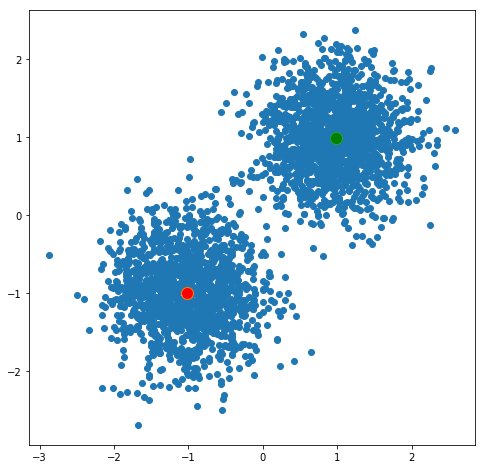

In [3]:
clst = KMeans(n_clusters=2, random_state=2342)
clst.fit(X)
mu = clst.cluster_centers_
plot_cluster_data(X, mu = mu)

## Посмотрим, как с каждым шагом меняется положение центроидов

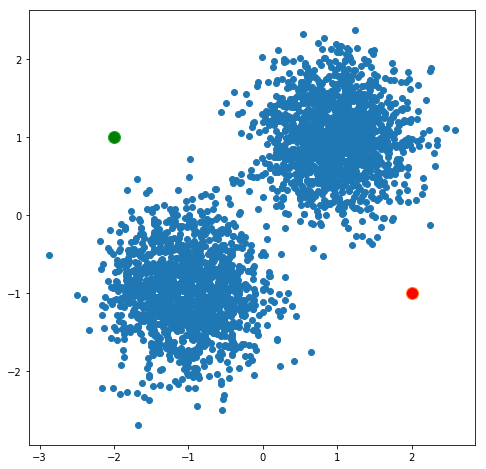

In [4]:
def update_labels(X, mu):
    c = np.argmax(np.c_[np.sum(np.power(X - mu[0,:], 2), axis=1), 
                        np.sum(np.power(X - mu[1,:], 2), axis=1)], 
                  axis=1)
    return c

def update_cluster_centers(X, c):
    ix = np.where(c==1)
    mu[0,:] = np.mean(X[ix,:], axis=1)
    ix = np.where(c==0)
    mu[1,:] = np.mean(X[ix,:], axis=1)
    return mu



k = 2
mu = np.array([[2.0,-1.0], [-2.0,1.0]])
plot_cluster_data(X, mu=mu)

Iteration 0:
...updating labels:


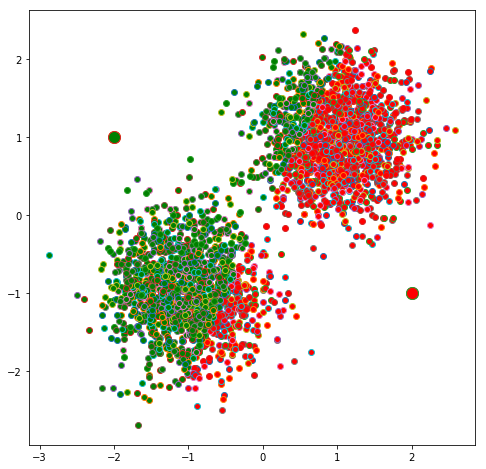

...updating centers:


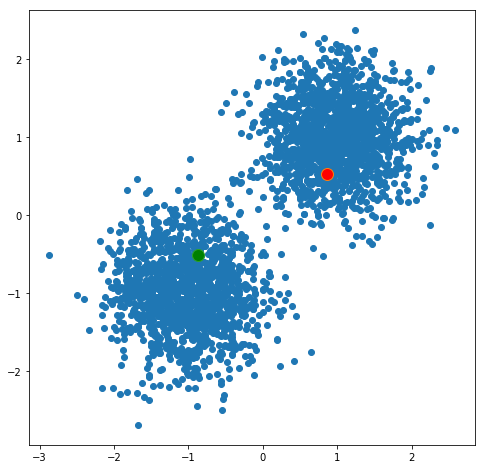

Iteration 1:
...updating labels:


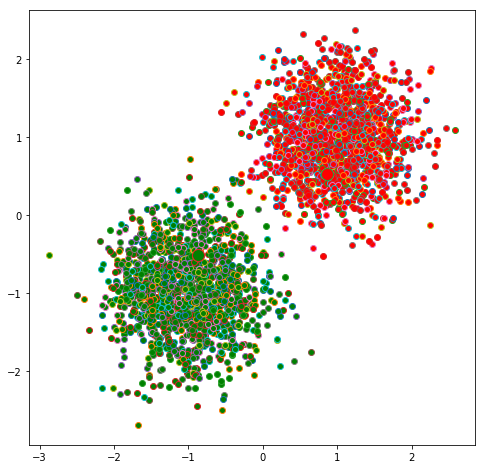

...updating centers:


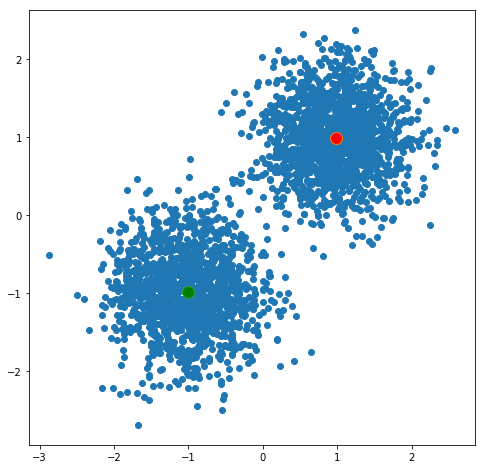

In [5]:
niter = 2
for it in range(niter):
    print('Iteration ' + str(it) + ':')
    c = update_labels(X, mu)
    print('...updating labels:')
    plot_cluster_data(X, c=c, mu=mu)
    print('...updating centers:')
    mu = update_cluster_centers(X, c)
    plot_cluster_data(X, mu=mu)

# Резюме
**Достоинства:**
* Быстрый
* Масштабируемый (есть готовые реализации на SparkML и Apache Mahout)
* Простой

**Недостатки;**
* Не умеет определять число кластеров

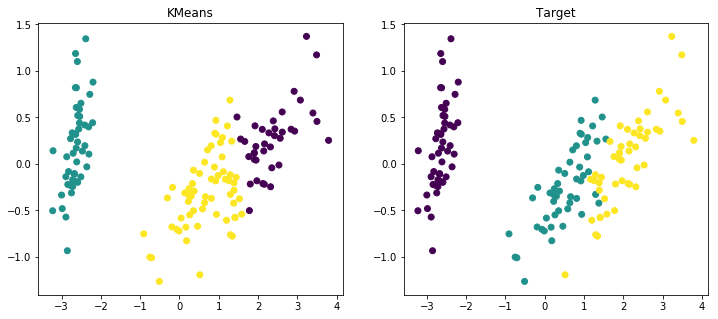

In [25]:
from sklearn.datasets import load_iris
X, y = load_iris()['data'], load_iris()['target']

from sklearn.decomposition import PCA

X_transform = PCA(n_components=2).fit_transform(X) # Сожмём до 2 признаков, чтобы было удобно визуализировать
from sklearn.cluster import KMeans

clst = KMeans(n_clusters=3)
preds = clst.fit_predict(X)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('KMeans')
plt.scatter(X_transform[:,0], X_transform[:,1], c=preds)

plt.subplot(122)
plt.title('Target')
plt.scatter(X_transform[:,0], X_transform[:,1], c=y) 

# Метрики качества для кластеризации

ARI

AMI

Homogenity

Completeness

V-measure

Silhouette

In [33]:
from sklearn import metrics

def get_metrics(X, y, preds):
    return {
        'ARI': metrics.adjusted_rand_score(y, preds),
        'AMI': metrics.adjusted_mutual_info_score(y, preds),
        'Homogenity': metrics.homogeneity_score(y, preds),
        'Completeness': metrics.completeness_score(y, preds),
        'V-measure': metrics.v_measure_score(y, preds),
        'Silhouette': metrics.silhouette_score(X, preds)}

get_metrics(X, y, preds)

{'ARI': 0.7302382722834697,
 'AMI': 0.7483723933229484,
 'Homogenity': 0.7514854021988338,
 'Completeness': 0.7649861514489815,
 'V-measure': 0.7581756800057784,
 'Silhouette': 0.5525919445213676}

# AffinityPropagation
Основная идея AffinityPropagation - устраивать между точками голосование по выбору лучшего кандидата на позицию центроида (губернатора) кластера (региона). В алгоритме три матрицы - S (близость между точками), R (ответственность, готовность каждой точки отдать свой голос второй) и A (доступность, насколько кандидат готов удовлетворять интересы своего избирателя)

**Параметры:**
* **affinity** в SkLearn - по какой формуле считать близость


![](https://hsto.org/files/9fc/34a/b55/9fc34ab559fb4be4b23928ce18619a28.png)

In [46]:
from sklearn.cluster import AffinityPropagation

clst = AffinityPropagation()
pred = clst.fit_predict(X)
get_metrics(X, y, pred)

{'ARI': 0.48033793286957843,
 'AMI': 0.5169514470691752,
 'Homogenity': 0.9149410296693686,
 'Completeness': 0.5276002057338901,
 'V-measure': 0.6692676280452976,
 'Silhouette': 0.35155761864245394}

In [47]:
n_clusters = len(clst.cluster_centers_)
n_clusters

7

# DBSCAN

Идея алгоритма - формировать точки в кластеры на основе их близости. Если в некотором радиусе R для точки не меньше N соседей, то точка относится к тому же кластеру, что и эти соседи. Если точек меньше, но >0, то это сомнительная точка. Если в окрестности точки нет ни одного соседа, то это выброс. Также можно сливать маленькие кластеры с более крупными

**Параметры:**
* R (**eps** в SkLearn) - радиус
* N (**min_samples** в SkLearn) - минимальное число соседей 
* **metric** в SkLearn - по какой формуле считать близость

![](https://hsto.org/files/0ba/54b/abe/0ba54babe162458bb9f8e004e5329cfa.png)

In [38]:
from sklearn.cluster import DBSCAN

clst = DBSCAN()
pred = clst.fit_predict(X)
get_metrics(X, y, pred)

{'ARI': 0.5206185241703302,
 'AMI': 0.5543650737746607,
 'Homogenity': 0.5599460100861128,
 'Completeness': 0.6565579648058795,
 'V-measure': 0.6044156375501386,
 'Silhouette': 0.4858423545758963}

In [43]:
n_componens = len(clst.components_)
n_componens

117

# Полезные ссылки

* [Список](http://scikit-learn.org/stable/modules/clustering.html) методов кластеризации в SkLearn с описанием того, когда какой использовать